## Qiskit Projects

This document contains several projects in the field of quantum computations. These projects are for educational purposes only, and may even be deemed problems that we try to solve, rather than projects. These are implemented using the pyhon library `qiskit`, which provides a quantum simulator that simulates a quantum circuit and the outcome is ideally what one expects on a real quantum device. Although real quantum devices are noisy and we never really get a perfect answer, there is always some noise.

### Quantum Random Number Generator

Essentially, quantum random number generators utilize the Hadamard gate to create a superposition of qubits. This gate transforms qubits from the 0 state to an equal superposition of the 0 and 1 states. Consequently, when the quantum circuit concludes, there is an equal likelihood of measuring a qubit value of 0 or 1. By treating a sequence of qubits as a binary value, applying the Hadamard gate to each qubit and subsequently performing a measurement, a random bitstring and, consequently, a random number can be generated.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumRegister, ClassicalRegister, execute
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import plot_state_city

In [83]:
def real_map(value, leftMin, leftMax, rightMin, rightMax):
    # Maps one range to another
    # Figure out how 'wide' each range is
    leftSpan = leftMax - leftMin
    rightSpan = rightMax - rightMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - leftMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return rightMin + (valueScaled * rightSpan)


def QRandNum(lb, ub):
    # Quantum Random Number generator
    # Select the number of qubits 
    qubits = int(np.log2(ub-lb))
    q = QuantumRegister(qubits, 'q')
    circ = QuantumCircuit(q)
    c0 = ClassicalRegister(2, 'c0')
    circ.add_register(c0)

    for i in range(qubits):
        circ.h(q[i])

    for i in range(qubits):
        circ.measure(q[i], c0)

    backend = Aer.get_backend('statevector_simulator')
    job = execute(circ, backend)
    #print(job.status())
    result = job.result()
    output = np.asarray(result.get_statevector(circ))

    num = 0
    for i in range(len(output)):
        if output[i] != 0:
            num = i
    
    y = real_map(num + 1 , 1, 2**qubits, lb, ub)
    return y

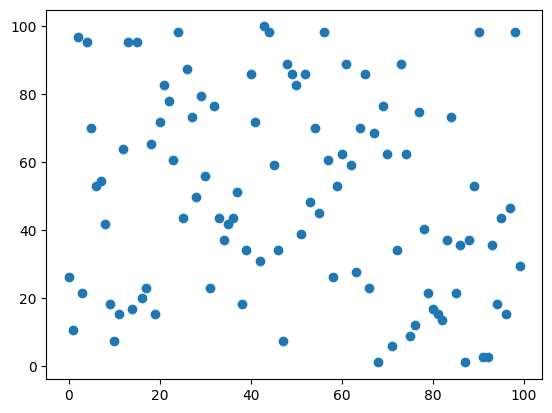

In [89]:
x = []
for i in range(100):
    x.append(QRandNum(1, 100))

plt.scatter(range(0, 100), x)

Quantum number generators are an important tool in the Quantum Key Distribution problem. We hope to come back to it later.

###  Grover’s Search Algorithm

Grover's algorithm has three main components. 
1. First, we begin by creating a superposition of all $2^n$ computational basis states by applying a Hadamard ($H$) gate on each qubit starting off in the state $\vert0\rangle^{\otimes n}$. Here, the exponent $\otimes n$ means that we have a tensor product of the states of $n$ qubits. 
2. Second, we apply an Oracle operator to mark the appropriate elements among the $2^n$ elements. The oracle operator applies a coefficient of $-1$ to each of the marked elements.
3. Third, we apply a Diffusion operator, or diffuser, which inverts the amplitude of all elements about the average amplitude.

Putting these components together, and applying the Oracle and Diffusion operators $O(\sqrt{N = 2^n})$ times, Grover's algorithm allows us to successfully determine the elements that were marked by the Oracle operator with high probability. This is shown in the block diagram above, where the quantum circuit for Grover's algorithm is depicted with a measurement in the end to read out the qubits.

The goal is to implement Grover's algorithm by creating a quantum circuit that has the marked element `01101`. We will see that the algorithm outputs the marked element with probability greater than $99\%$.

In [98]:
from qiskit.extensions import UnitaryGate
from qiskit.circuit.library import GroverOperator
from qiskit.visualization import plot_histogram

def grover_search(marked_elt: str):
    index = int(marked_elt, 2)

    arr = np.identity(2**(len(marked_elt)))
    arr[index, index] = -1

    unitary_gate = UnitaryGate(arr)

    oracle = QuantumCircuit(5)
    oracle.compose(unitary_gate, qubits=range(5), inplace=True)
    #oracle.draw(output='mpl')

    grover_op = GroverOperator(oracle)

    init = QuantumCircuit(5, 5)
    init.h(range(5))

    qc = init.compose(grover_op)
    qc.compose(grover_op, inplace=True)
    qc.compose(grover_op, inplace=True)
    qc.compose(grover_op, inplace=True)

    qc.measure(range(5),range(5))
    #qc.draw(output='mpl')

    sim = Aer.get_backend('aer_simulator')
    t_qc = transpile(qc, sim)
    counts = sim.run(t_qc).result().get_counts()

    return counts

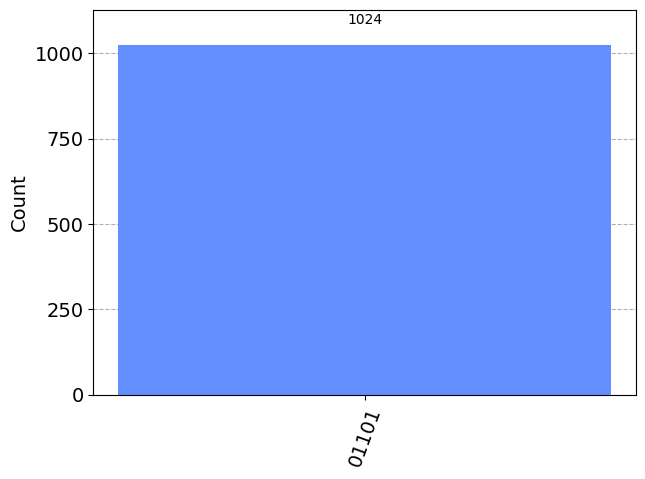

In [99]:
counts = grover_search('01101')
plot_histogram(counts)

The following implementation allows for multiple marked elements, entered as a list of bit strings. The length of the bitstrings must be equal.

In [104]:
def grover_circuit(marked_elts: list):

    n = len(marked_elts[0])
    indices = [int(marked_elt, 2) for marked_elt in marked_elts]
    
    arr = np.identity(2**n)
    for index in indices:
        arr[index, index] = -1
    
    unitary_gate = UnitaryGate(arr)

    oracle = QuantumCircuit(n)
    oracle.compose(unitary_gate, qubits=range(n), inplace=True)
    
    # grover operator
    grover_op = GroverOperator(oracle)

    init = QuantumCircuit(n, n)
    init.h(range(n))

    r = int(np.pi/4*np.sqrt(2**n/len(indices)))
    print(f'{n} qubits, basis states {indices} marked, {r} rounds')

    qc = init.compose(grover_op)
    for _ in range(1, r):
        qc.compose(grover_op, inplace=True)

    qc.measure(range(n),range(n))
    return qc

Let us take two marked elements, `001101` and `101010`.

6 qubits, basis states [13, 42] marked, 4 rounds


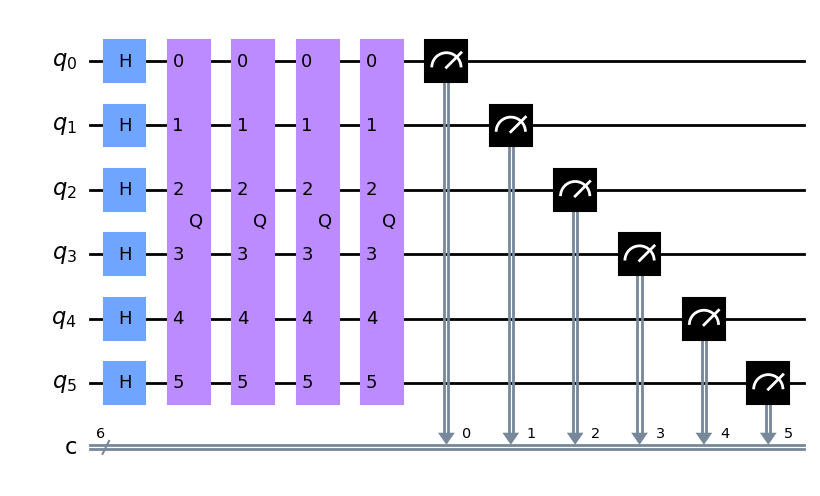

In [106]:
q_circuit = grover_circuit(['001101', '101010'])
q_circuit.draw('mpl')

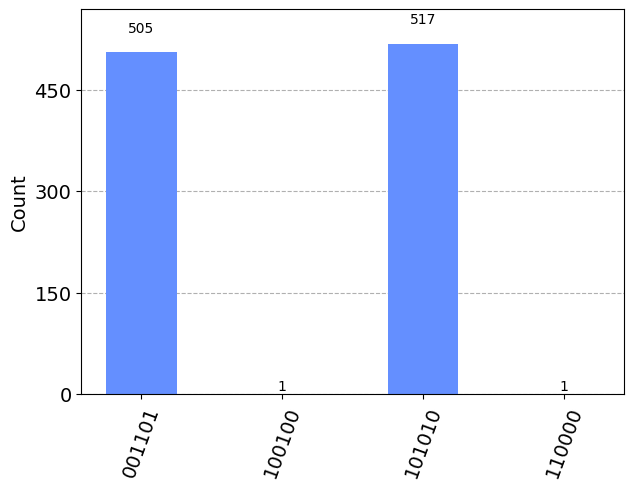

In [107]:
sim = Aer.get_backend('aer_simulator')
t_qc = transpile(q_circuit, sim)
counts = sim.run(t_qc).result().get_counts()
plot_histogram(counts)